In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 10})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 10}
# plt.rcParams['text.usetex'] = True
# plt.rc('font', **font)

## test 

    R4B0 - yes SR no hosing
    RWB0 - no SR no hosing

In [4]:
ySR = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_R4B1/'
nSR = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_RWB0/'

In [5]:
def make_yearlist(yrst, yrend, tr, dtype = 'grid_T'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/ModelRuns/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        #print(t2)
        ylist.append(t2[0])
    return ylist

## get out wfo which is actually empmp

In [6]:

ySR = 'TOM12_TJ_R4B1/'
nSR = 'TOM12_TJ_RWB0/'

ex = False
if ex:
    ySRs = xr.open_mfdataset(make_yearlist(1950,2020,ySR))
    nSRs = xr.open_mfdataset(make_yearlist(1950,2020,nSR))
    
    single_var = ySRs['wfo']
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf('./R4B1_wfo.nc')

    single_var = nSRs['wfo']
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf('./RWB0_wfo.nc')



## copy over meshmasks

In [7]:
ex = False
if ex:
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

    names  = ['ATL', 'PAC', 'IND', 'SO', 'ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

    for n in names:

        var_copy = tmesh['tmaskutil'].copy()
        var_copy.name = n
        udelej = np.zeros([1,149, 182])
        udelej[:,:,:] = tmask[n][:]
        var_copy.data = udelej
        tmesh[n] =var_copy

    tmesh.to_netcdf('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

    tmesh

## look at the mask

Text(0.5, 0.98, 'colours assigned')

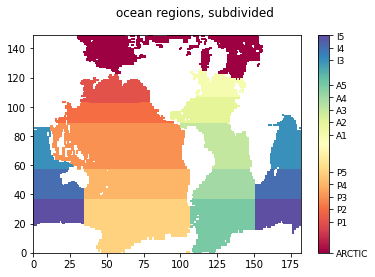

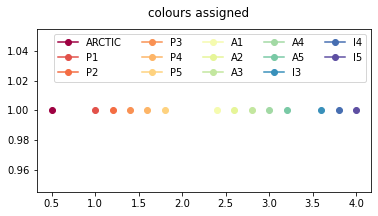

In [8]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

## look at empmr in variants of gcb runs (toggle)

In [9]:
show = False
if show:

    colors_dict = {
        'R4B1':  '#6db8ff',
        'R4B0': 'k',
        'R4A1': '#de4231', 
        'R4C1': '#f3c108',
        'R4D1': '#02954f',
        'RWB0': 'grey',
    }

    lab_dic = {
        'R4B1':  'B1 (GCB2024)',
        'R4B0': 'B0 - yes SR',
        'R4A1': 'A1 (GCB2024)', 
        'R4C1': 'C1 (GCB2024)',
        'R4D1': 'D1 (GCB2024)',
        'RWB0': 'B0 - no SR',
    }


    ls_dic = {
        'R4B1':  '-','R4B0': ':','R4A1': '-', 
        'R4C1': ':','R4D1': ':','RWB0': ':',
    }

    lw_dic = {
        'R4B1':  1,'R4B0': 2.5,'R4A1': 1, 
        'R4C1': 2.5,'R4D1': 2.5,'RWB0': 2.5,
    }

    mods = ['R4B1','RWB0','R4B0']#'R4D1',

    fact = 0.9
    fig, axs = plt.subplots(5,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    regs = ['tmaskutil','ATL','ARCTIC','A1','A2']

    ind = 0


    for treg in regs:
        for mod in mods:

            tvar = 'wfo'
            w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
            tmask['test'] = tmask['csize']*tmask[treg]
            w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
            tval = w.indexes['time_counter'].to_datetimeindex()
            w['time_counter'] = tval
            w1 = w.groupby('time_counter.year').mean()
            axs[ind*2].plot(w1.year, w1, linestyle = '-',\
                     color = colors_dict[mod], lw = 2, label = f'{mod} {lab_dic[mod]}')
            axs
            tvar = 'sos'
            w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
            tmask['test'] = tmask['csize']*tmask[treg]
            w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
            tval = w.indexes['time_counter'].to_datetimeindex()
            w['time_counter'] = tval
            w1 = w.groupby('time_counter.year').mean()
            axs[ind*2+1].plot(w1.year, w1, linestyle = '-',\
                     color = colors_dict[mod], lw = 2, label = f'{mod} {lab_dic[mod]}')

            axs[ind*2+0].set_title(f'{treg} empmr (saved as wfo)')
            axs[ind*2+1].set_title(f'{treg} surface salinity')
        ind= ind+1

    axs[1].legend(bbox_to_anchor = [1,1])

    plt.tight_layout()

## extract salinity and empave for the targeted SR/no SR experiment 

KDD0 / KDB0 or KW of the same

In [10]:
ex = False
if ex:
    
    print('st')
    tdat = 'wfo'
    ySR = 'KDD0'
    nSR = 'KWD0'

    ySRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{ySR}'))
    nSRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{nSR}'))
    
    single_var = ySRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{ySR}_{tdat}.nc')

    single_var = nSRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{nSR}_{tdat}.nc')

    ySR = 'KDB0'
    nSR = 'KWB0'

    ySRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{ySR}'))
    nSRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{nSR}'))
    
    single_var = ySRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{ySR}_{tdat}.nc')

    single_var = nSRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{nSR}_{tdat}.nc')
 
    print('hw')
    tdat = 'sos'
    ySR = 'KDD0'
    nSR = 'KWD0'

    ySRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{ySR}'))
    nSRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{nSR}'))
    
    single_var = ySRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{ySR}_{tdat}.nc')

    single_var = nSRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{nSR}_{tdat}.nc')

    ySR = 'KDB0'
    nSR = 'KWB0'

    ySRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{ySR}'))
    nSRs = xr.open_mfdataset(make_yearlist(1950,2020,f'TOM12_TJ_{nSR}'))
    
    single_var = ySRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{ySR}_{tdat}.nc')

    single_var = nSRs[tdat]
    new_ds = single_var.to_dataset()
    new_ds.to_netcdf(f'./{nSR}_{tdat}.nc')

### visualize the same

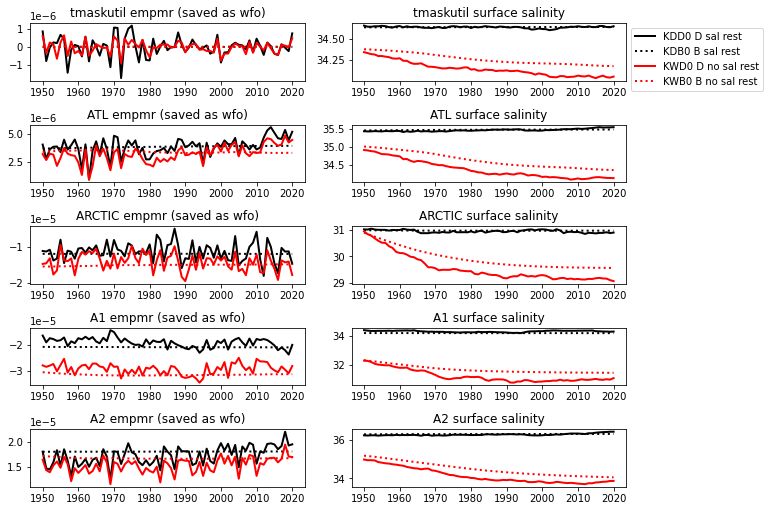

In [11]:
view = False #toggle

#KDD0 / KDB0 or KW of the same

colors_dict = {
    'KDD0':  'k',
    'KDB0': 'k',
    'KWD0': 'r', 
    'KWB0': 'r',

}

lab_dic = {
    'KDD0':  'D sal rest',
    'KDB0': 'B sal rest',
    'KWD0': 'D no sal rest', 
    'KWB0': 'B no sal rest',
}


ls_dic = {
    'KDD0':  '-',
    'KDB0': ':',
    'KWD0': '-', 
    'KWB0': ':',
}

lw_dic = {
    'KDD0':  1,
    'KDB0': 2,
    'KWD0': 1, 
    'KWB0': 2,
}

view = False
if view:

    mods = ['KDD0','KDB0','KWD0', 'KWB0']#'R4D1',

    fact = 0.9
    fig, axs = plt.subplots(5,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    regs = ['tmaskutil','ATL','ARCTIC','A1','A2']

    ind = 0


    for treg in regs:
        for mod in mods:

            tvar = 'wfo'
            w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
            tmask['test'] = tmask['csize']*tmask[treg]
            w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
            tval = w.indexes['time_counter'].to_datetimeindex()
            w['time_counter'] = tval
            w1 = w.groupby('time_counter.year').mean()
            axs[ind*2].plot(w1.year, w1, linestyle = ls_dic[mod],\
                     color = colors_dict[mod], lw = 2, label = f'{mod} {lab_dic[mod]}')
            axs
            tvar = 'sos'
            w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
            tmask['test'] = tmask['csize']*tmask[treg]
            w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
            tval = w.indexes['time_counter'].to_datetimeindex()
            w['time_counter'] = tval
            w1 = w.groupby('time_counter.year').mean()
            axs[ind*2+1].plot(w1.year, w1, linestyle = ls_dic[mod],\
                     color = colors_dict[mod], lw = 2, label = f'{mod} {lab_dic[mod]}')

            axs[ind*2+0].set_title(f'{treg} empmr (saved as wfo)')
            axs[ind*2+1].set_title(f'{treg} surface salinity')
        ind= ind+1

    axs[1].legend(bbox_to_anchor = [1,1])

    plt.tight_layout()

### amoc helper fxns

In [12]:
def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

#R4B0_moc = make_yearlist(1920, 2023, 'TOM12_TJ_R4B0')

#mods = ['KDD0','KDB0','KWD0', 'KWB0']



## visualize amoc

In [13]:
amoc = False
if amoc:
    
    KDD0_moc = make_yearlist(1920, 2023, 'TOM12_TJ_KDD0')
    KWD0_moc = make_yearlist(1920, 2023, 'TOM12_TJ_KWD0')
    KDB0_moc = make_yearlist(1920, 2023, 'TOM12_TJ_KDB0')
    KWB0_moc = make_yearlist(1920, 2023, 'TOM12_TJ_KWB0')


    KDD0_mocdat = xr.open_mfdataset(KDD0_moc) 
    KDB0_mocdat = xr.open_mfdataset(KDB0_moc) 
    KWD0_mocdat = xr.open_mfdataset(KWD0_moc) 
    KWB0_mocdat = xr.open_mfdataset(KWB0_moc) 
    nicetime  = KDD0_mocdat.indexes['time_counter'].to_datetimeindex()

    KDD0_max_amoc = get_max_amoc(KDD0_mocdat)
    KDB0_max_amoc = get_max_amoc(KDB0_mocdat)
    KWD0_max_amoc = get_max_amoc(KWD0_mocdat)
    KWB0_max_amoc = get_max_amoc(KWB0_mocdat)


    data_vars = {'amoc':(['time_counter'], KDD0_max_amoc,),}
    coords = {'time_counter': (['time_counter'], nicetime)}
    KDD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

    data_vars = {'amoc':(['time_counter'], KDB0_max_amoc,),}
    coords = {'time_counter': (['time_counter'], nicetime)}
    KDB0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)
    
    data_vars = {'amoc':(['time_counter'], KWD0_max_amoc,),}
    coords = {'time_counter': (['time_counter'], nicetime)}
    KWD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

    data_vars = {'amoc':(['time_counter'], KWB0_max_amoc,),}
    coords = {'time_counter': (['time_counter'], nicetime)}
    KWB0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

    KDD0yr = KDD0_max_amoc.groupby('time_counter.year').mean()
    KDB0yr = KDB0_max_amoc.groupby('time_counter.year').mean()
    KWD0yr = KWD0_max_amoc.groupby('time_counter.year').mean()
    KWB0yr = KWB0_max_amoc.groupby('time_counter.year').mean()

    

    fact = 0.9
    fig, axs = plt.subplots(2,1, figsize=(8*fact, 12*fact), facecolor='w', edgecolor='k')

    axs[0].plot(nicetime, KDD0_max_amoc.amoc, label = 'D, sal rest', color = colors_dict['KDD0'])
    axs[0].plot(nicetime, KDB0_max_amoc.amoc, label = 'B, sal rest', color = colors_dict['KDB0'], linestyle = ':')
    axs[0].plot(nicetime, KWD0_max_amoc.amoc, label = 'D, no sal rest', color = colors_dict['KWD0'])
    axs[0].plot(nicetime, KWB0_max_amoc.amoc, label = 'B, no sal rest', color = colors_dict['KWB0'], linestyle = ':')

    axs[0].set_title('AMOC, KAP12 (physics-only cal12 version)')
    axs[0].legend()

    axs[1].plot(KDD0yr.year, KDD0yr.amoc, label = 'D, sal rest', color = colors_dict['KDD0'])
    axs[1].plot(KDD0yr.year, KDB0yr.amoc, label = 'D, sal rest', color = colors_dict['KDD0'])
    axs[1].plot(KDD0yr.year, KWD0yr.amoc, label = 'D, sal rest', color = colors_dict['KWD0'])
    axs[1].plot(KDD0yr.year, KWB0yr.amoc, label = 'D, sal rest', color = colors_dict['KWD0'])

    # axs[1].plot(nicetime, KDB0_max_amoc.amoc, label = 'B, sal rest', color = colors_dict['KDB0'], linestyle = ':')
    # axs[1].plot(nicetime, KWD0_max_amoc.amoc, label = 'D, no sal rest', color = colors_dict['KWD0'])
    # axs[1].plot(nicetime, KWB0_max_amoc.amoc, label = 'B, no sal rest', color = colors_dict['KWB0'], linestyle = ':')

    axs[0].set_title('AMOC, KAP12 (physics-only cal12 version) (monthly and yearly)')
    axs[0].legend()
    axs[0].set_ylabel('Sv')

## what does the precipitation climatology look like in the north atlantic

### make era precipitation files more easy to look at

In [17]:
import xarray as xr
import numpy as np
import glob

ex = False

if ex:
    for yr in range(1940,2023):
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        #ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosingArun/'
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w2 = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left')
        merged_dataset = xr.merge([w, w2])
        merged_dataset['time_counter'] = times
        merged_dataset.to_netcdf(f'./data/ERAprecip_{yr}.nc')

In [18]:
def make_yearlistERA(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data/ERAprecip_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


## visualise rain and snow climatologies and empmr climatologies

In [19]:
view = True
if view:

    tvar = 'wfo'
    KDD0 = xr.open_dataset(f'./data/KDD0_{tvar}.nc')
    KWD0 = xr.open_dataset(f'./data/KWD0_{tvar}.nc')
    KDB0 = xr.open_dataset(f'./data/KDB0_{tvar}.nc')
    KWB0 = xr.open_dataset(f'./data/KWB0_{tvar}.nc')

    KDD0['time_counter'] = KDD0.indexes['time_counter'].to_datetimeindex()
    KWD0['time_counter'] = KWD0.indexes['time_counter'].to_datetimeindex()
    KDB0['time_counter'] = KDB0.indexes['time_counter'].to_datetimeindex()
    KWB0['time_counter'] = KWB0.indexes['time_counter'].to_datetimeindex()

    KWB0_clim = KWB0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.season").mean("time_counter")
    KDB0_clim = KDB0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.season").mean("time_counter")
    KWD0_clim = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.season").mean("time_counter")
    KDD0_clim = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.season").mean("time_counter")
    
    
    seasonal_avg = xr.open_dataset('./data/era_1980-2020-clim.nc')
    fact = 2
    fig, axs = plt.subplots(2,4, figsize=(12*fact, 7*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    seas = ['DJF','MAM','JJA','SON']

    for i in range(0,4):
        axs[i].pcolormesh(seasonal_avg.prra.sel(season = seas[i]).values, vmin = 0, vmax = 7e-5)
        im1 = axs[i+4].pcolormesh(seasonal_avg.prsn.sel(season = seas[i]).values, vmin = 0, vmax = 7e-5)
        axs[i].set_title(f'{seas[i]} rain')
        axs[i+4].set_title(f'{seas[i]} snow')
    cbar = fig.colorbar(im1, ax=axs, orientation='vertical')
    cbar.set_label("kg/m2/s")
    
    seasonal_avg = xr.open_dataset('./data/era_1980-2020-clim.nc')
    fact = 1.5
    fig, axs = plt.subplots(3,4, figsize=(12*fact, 7*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    seas = ['DJF','MAM','JJA','SON']

    for i in range(0,4):
        axs[i].pcolormesh(KWB0_clim.wfo.sel(season = seas[i]).values, vmin = -7e-5, vmax = 7e-5, cmap = cm.balance)
        axs[i].set_title(f'wfo (no SR) {seas[i]}')
        im1 = axs[i+4].pcolormesh(KDB0_clim.wfo.sel(season = seas[i]).values, vmin = -7e-5, vmax = 7e-5, cmap = cm.balance)
        axs[i+4].set_title(f'wfo (yes SR) {seas[i]}')
        diff = KDB0_clim.wfo.sel(season = seas[i]).values - KWB0_clim.wfo.sel(season = seas[i]).values
        axs[i+8].pcolormesh(diff, vmin = -7e-5, vmax = 7e-5, cmap = cm.balance)
        axs[i+8].set_title(f'(yes SR - no SR) {seas[i]}')

    for i in range(0,12):
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    cbar = fig.colorbar(im1, ax=axs, orientation='vertical')
    cbar.set_label("kg/m2/s")

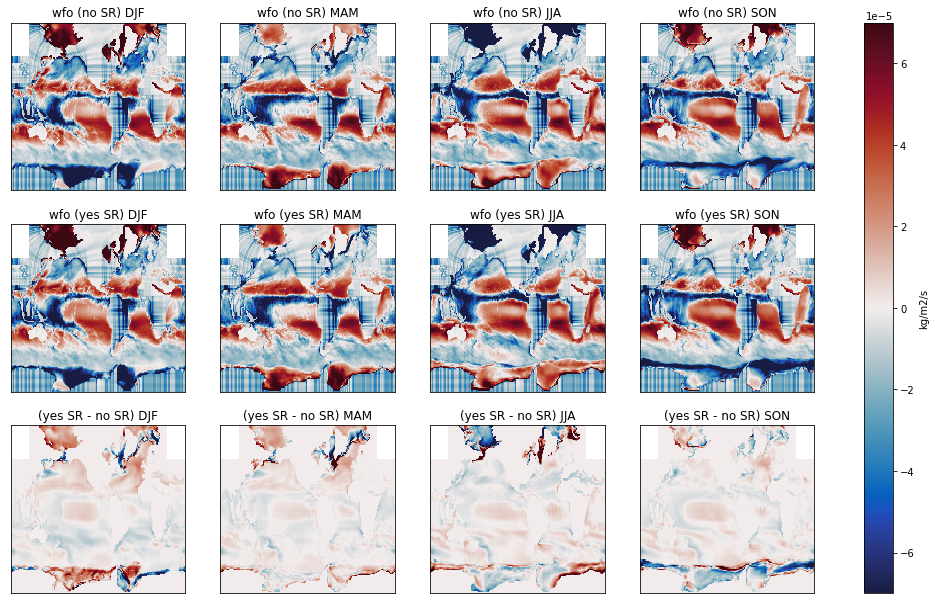

## how different is wfo from D runs vs B runs - different enough, use D runs
    different enough that it matters

In [23]:
if view:
    for i in range(0,4):
        diff = KDB0_clim.wfo.sel(season = seas[i]).values - KWB0_clim.wfo.sel(season = seas[i]).values
        print(np.nanmean(diff))
        diff = KDD0_clim.wfo.sel(season = seas[i]).values - KWD0_clim.wfo.sel(season = seas[i]).values
        print(np.nanmean(diff))

        print()

1.0180553e-06
4.938722e-07

7.9090006e-07
6.2496855e-07

2.798859e-07
4.3271592e-07

-9.903014e-07
-7.032698e-07



## get climatological difference

In [24]:
KWB0_40y = KWB0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDB0_40y = KDB0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

diff_D = KDD0_40y - KWD0_40y
diff_D = diff_D.rename({"month": "time"})
diff_clim = diff_D.wfo.values
print(np.shape(diff_clim))

#days of year
nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

lydiff = np.zeros([366,149,182])
nlydiff = np.zeros([365,149,182])

#corrector
for i in range(0,12):
    
    lydiff[lys[i]:lys[i+1],:,:] = diff_clim[i,:,:]
    nlydiff[nlys[i]:nlys[i+1],:,:] = diff_clim[i,:,:]
    
    


(12, 149, 182)


# BONUS RAIN correction code

[ 1.26639898e-05  1.26930136e-05  4.46898321e-06  4.53194571e-06
 -2.70633682e-05  3.63443687e-05  2.47298049e-05 -1.41073906e-06
 -7.23568519e-07  1.86354919e-06 -4.02436672e-06  1.07822416e-07]
1.266399e-05


(0.0, 365.0)

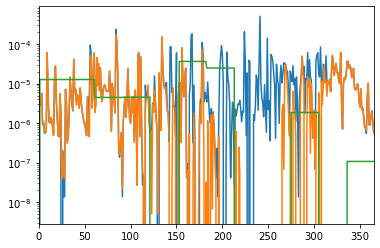

In [25]:
#w['prra_corr'] = w.prra - lydiff


nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

## open file
yr = 2000
w = xr.open_dataset(f'./data/ERAprecip_{yr}.nc')


## get yearly ts of data at one point

y = 120; x = 100
noday = len(w.time_counter)
prra_adj = np.zeros_like(w.prra.values)
t_prra = w.prra[:,y,x]
t_prra_adj = np.zeros_like(w.prra[:,y,x])
plt.figure()
plt.plot(t_prra)

t_prsn = w.prsn[:,y,x]
t_prsn_adj = np.zeros_like(w.prra[:,y,x])

plt.plot(t_prsn)
plt.plot(lydiff[:,y,x])
## get out correct month
mon = 1
if noday == 366: monar = lys
else: monar = nlys


bonus_rain = diff_clim[mon-1,y,x]
print(diff_clim[:,y,x])
print(bonus_rain)

plt.yscale('log')

plt.xlim([0,365])
## get weights of rain (for each day in month, how much of the month's rain falls then?)

## get total bonus rain

## subtract bonus rain from original rain







## 3 ways to do correction rain can be negative in this flux correction.

let's do the corrections 3 ways:

- monthly-avg N. Atl only KFD0
- yearly-avg N. Atl only KFD1 
- yearly-avg global KFD2

reading: Park 2016 who did something similar



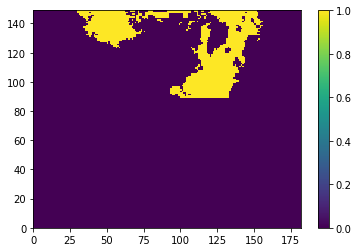

In [27]:
# get a monthly-avg flux corr (ly, nly) done
# get a yearly-avg flux corr (ly, nly) done
# get a mask for NATL 0.5, 2.4, 2.6

KWD0_40m = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDD0_40m = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

diff_Dm = KDD0_40m - KWD0_40m

KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")

diff_Dy = KDD0_40y - KWD0_40y

nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

lydiff_m = np.zeros([366,149,182])
nlydiff_m = np.zeros([365,149,182])
lydiff_y = np.zeros([366,149,182])
nlydiff_y = np.zeros([365,149,182])

#corrector
for i in range(0,12):
    
    lydiff_m[lys[i]:lys[i+1],:,:] = diff_Dm.wfo[i,:,:]
    nlydiff_m[nlys[i]:nlys[i+1],:,:] = diff_Dm.wfo[i,:,:]
    
for i in range(0,365):
    nlydiff_y[i,:,:] = diff_Dy.wfo[:,:]
for i in range(0,366):
    lydiff_y[i,:,:] = diff_Dy.wfo[:,:]
    
maskc = np.copy(maskno)

#mask out the atlantic (atl = 1, all else is 0)
maskc[maskno == 0.5] = 10
maskc[maskno == 2.4] = 10
maskc[maskno == 2.6] = 10

maskc[np.isnan(maskc)]= 0
maskc[maskc < 10]= 0
maskc[maskc == 10] = 1
im = plt.pcolormesh(maskc)
plt.colorbar(im)

ly_atl_broad = np.zeros([366,149,182])
nly_atl_broad = np.zeros([365,149,182])

for i in range(0,365):
    nly_atl_broad[i,:,:] = maskc
for i in range(0,366):
    ly_atl_broad[i,:,:] = maskc
    
#monthly atl corr
lydiff_m_atl = lydiff_m * ly_atl_broad
nlydiff_m_atl = nlydiff_m * nly_atl_broad

# yearly atl corr
lydiff_y_atl = lydiff_y * ly_atl_broad
nlydiff_y_atl = nlydiff_y * nly_atl_broad

# yearly full year corr is lydiff_y, nly_diff_y

## we now have the following flux corections
    
    #monthly atl corr
    lydiff_m_atl = lydiff_m * ly_atl_broad
    nlydiff_m_atl = nlydiff_m * nly_atl_broad

    # yearly atl corr
    lydiff_y_atl = lydiff_y * ly_atl_broad
    nlydiff_y_atl = nlydiff_y * nly_atl_broad

    # yearly full year corr
    lydiff_y
    nly_diff_y

In [28]:
lydiff_m_atl[np.isnan(lydiff_m_atl)] = 0 
nlydiff_m_atl[np.isnan(nlydiff_m_atl)] = 0 
lydiff_y_atl[np.isnan(lydiff_y_atl)] = 0 
nlydiff_y_atl[np.isnan(nlydiff_y_atl)] = 0 
lydiff_y[np.isnan(lydiff_y)] = 0 
nlydiff_y[np.isnan(nlydiff_y)] = 0 

## produce the flux-corrected prra and prsn (prra is 

In [29]:
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False


ex = False

if ex:
    for yr in range(1920,1940):
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global yearly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prra'] = w['prra'] - lydiff_y
        else:
            w['prra'] = w['prra'] - nlydiff_y
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_13_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prra'] = w['prra'] - lydiff_y_atl
        else:
            w['prra'] = w['prra'] - nlydiff_y_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_13_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prra'] = w['prra'] - lydiff_m_atl
        else:
            w['prra'] = w['prra'] - nlydiff_m_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_13_y{yr}.nc')
        
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False

if ex:
    for yr in range(1920,1940):
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global yearly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prsn'] = w['prsn'] - lydiff_y
        else:
            w['prsn'] = w['prsn'] - nlydiff_y
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_14_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prsn'] = w['prsn'] - lydiff_y_atl
        else:
            w['prsn'] = w['prsn'] - nlydiff_y_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_14_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prsn'] = w['prsn'] - lydiff_m_atl
        else:
            w['prsn'] = w['prsn'] - nlydiff_m_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_14_y{yr}.nc')

## for 1920-1940, we use year 1990

In [30]:
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False


ex = False

if ex:
    for yr in range(1920,1940):
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global yearly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff_y
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_13_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff_y_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_13_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff_m_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_13_y{yr}.nc')
        
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False

if ex:
    for yr in range(1920,1940):
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global yearly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff_y
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_14_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff_y_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_14_y{yr}.nc')
        
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff_m_atl
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_14_y{yr}.nc')

1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939


## check what the monthly and yearly flux-corrected prra look like for 2 years 1971, 2015

3.260653361858394e-07
3.2944973576021394e-07
2.0315660625739542e-07


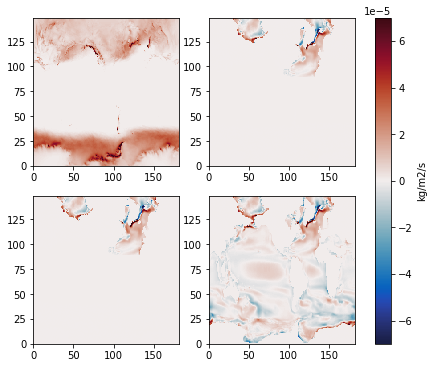

In [32]:
yr = 2020
fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/era5_bulk_14_y{yr}.nc',\
                   decode_times=False)
w2 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_14_y{yr}.nc',\
                   decode_times=False)
w3 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_14_y{yr}.nc',\
                   decode_times=False)
w4 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_14_y{yr}.nc',\
                   decode_times=False)

base = np.nanmean(w.prsn.values,axis = 0, )
axs[0].pcolormesh(base, vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[1].pcolormesh(base - np.nanmean(w2.prsn.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[2].pcolormesh(base - np.nanmean(w3.prsn.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[3].pcolormesh(base - np.nanmean(w4.prsn.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)

print(np.nanmean(base - np.nanmean(w2.prsn.values,axis = 0)))
print(np.nanmean(base - np.nanmean(w3.prsn.values,axis = 0)))
print(np.nanmean(base - np.nanmean(w4.prsn.values,axis = 0)))

cbar = fig.colorbar(im1, ax=axs, orientation='vertical')
cbar.set_label("kg/m2/s")


3.2606490857462727e-07
3.2944930814900194e-07
2.0315617864618048e-07


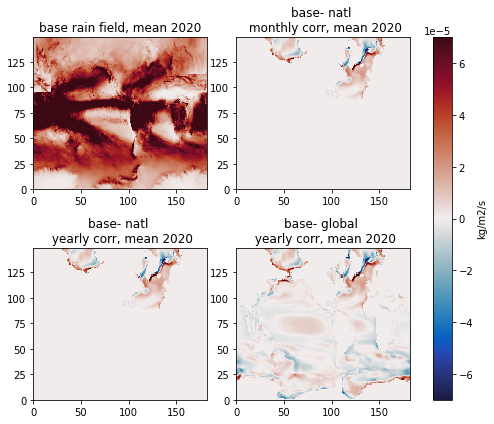

In [33]:
yr = 2020
fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/era5_bulk_13_y{yr}.nc',\
                   decode_times=False)
w2 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_13_y{yr}.nc',\
                   decode_times=False)
w3 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_13_y{yr}.nc',\
                   decode_times=False)
w4 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_13_y{yr}.nc',\
                   decode_times=False)

base = np.nanmean(w.prra.values,axis = 0, )
axs[0].pcolormesh(base, vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[1].pcolormesh(base - np.nanmean(w2.prra.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[2].pcolormesh(base - np.nanmean(w3.prra.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)
axs[3].pcolormesh(base - np.nanmean(w4.prra.values,axis = 0), vmin = -5e-5, vmax = 5e-5, cmap = cm.balance)

print(np.nanmean(base - np.nanmean(w2.prra.values,axis = 0)))
print(np.nanmean(base - np.nanmean(w3.prra.values,axis = 0)))
print(np.nanmean(base - np.nanmean(w4.prra.values,axis = 0)))


axs[0].set_title(f'base rain field, mean {yr}')
axs[1].set_title(f'base- natl \n monthly corr, mean {yr}')
axs[2].set_title(f'base- natl \n yearly corr, mean {yr}')
axs[3].set_title(f'base- global \n yearly corr, mean {yr}')

plt.tight_layout()
cbar = fig.colorbar(im1, ax=axs, orientation='vertical')
cbar.set_label("kg/m2/s")

## symlink all the forcing

In [34]:
import os

tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
tdirNY = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/'
tdirNM = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/'
tdirGY = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/'

link = False

if link:
    
    print('testing tym socialne divergentni')
    
    for y in range(1920,1940):
        print(y)
#         for b in range(8,16):
#             if ((b != 13) & (b != 14)):
#                 try:
#                     src = f'{tdirs}era5_bulk_{b}_y{y}.nc'
#                     dst = f'{tdirNY}era5_bulk_{b}_y{y}.nc'
#                     os.symlink(src,dst)
#                     dst = f'{tdirNM}era5_bulk_{b}_y{y}.nc'
#                     os.symlink(src,dst)
#                     dst = f'{tdirGY}era5_bulk_{b}_y{y}.nc'
#                     os.symlink(src,dst)
#                     print(f'year {y} bulk variable {b} GO!')
#                 except:
#                     print(f'didnt work for year {y} bulk variable {b}')
                    
        # try:
        #     src = f'{tdir}era5_bulk_13_y{y}.nc'
        #     dst = f'{tdir}era5_bulk_13_y{y}.nc'
        #     os.symlink(src,dst)
        #     print(f'year {y} bulk variable {b} GO!')
        # except:
        #     print(f'didnt work for year {y} bulk variable {b}')
        try:
            src = f'{tdirs}taux_1d_y{y}.nc'
            dst = f'{tdirNY}taux_1d_y{y}.nc'
            os.symlink(src,dst)
            dst = f'{tdirNM}taux_1d_y{y}.nc'
            os.symlink(src,dst)
            dst = f'{tdirGY}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirs}tauy_1d_y{y}.nc'
            dst = f'{tdirNY}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
            dst = f'{tdirNM}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
            dst = f'{tdirGY}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


testing tym socialne divergentni
1920
year {y} taux is off
year {y} tauy is off
1921
year {y} taux is off
year {y} tauy is off
1922
year {y} taux is off
year {y} tauy is off
1923
year {y} taux is off
year {y} tauy is off
1924
year {y} taux is off
year {y} tauy is off
1925
year {y} taux is off
year {y} tauy is off
1926
year {y} taux is off
year {y} tauy is off
1927
year {y} taux is off
year {y} tauy is off
1928
year {y} taux is off
year {y} tauy is off
1929
year {y} taux is off
year {y} tauy is off
1930
year {y} taux is off
year {y} tauy is off
1931
year {y} taux is off
year {y} tauy is off
1932
year {y} taux is off
year {y} tauy is off
1933
year {y} taux is off
year {y} tauy is off
1934
year {y} taux is off
year {y} tauy is off
1935
year {y} taux is off
year {y} tauy is off
1936
year {y} taux is off
year {y} tauy is off
1937
year {y} taux is off
year {y} tauy is off
1938
year {y} taux is off
year {y} tauy is off
1939
year {y} taux is off
year {y} tauy is off
we have shutdown


## check that the correction is about what we want

In [35]:
y = 1992
w = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globY/era5_bulk_13_y{y}.nc',\
                    decode_times = False)
w2 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlY/era5_bulk_13_y{y}.nc',\
                    decode_times = False)
w3 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_NatlM/era5_bulk_13_y{y}.nc',\
                    decode_times = False)
w0 = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ//era5_bulk_13_y{y}.nc',\
                    decode_times = False)
print(np.nanmean(w.prra))
print(np.nanmean(w2.prra))
print(np.nanmean(w3.prra))
print(np.nanmean(w0.prra))

2.8221853126755993e-05
2.8095559997253177e-05
2.8098944396827512e-05
2.842499e-05


## what do the metrics look like? specifically, surface salinity and amoc

In [36]:
ex = False

def make_yearlist(yrst, yrend, tr, dtype = 'grid_T'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/ModelRuns/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        #print(t2)
        ylist.append(t2[0])
    return ylist


if ex:
    
    print('st')
    tdat = 'wfo'
    
    tdats = ['wfo', 'sos']
    tpic = ['KFD0', 'KFD1','KFD2']
    
    for j in range(0,2):
        
        tdat = tdats[j]
        for i in range(0,3):

            ySR = tpic[i]
            print(f'{ySR} {tdat}')


            ySRs = xr.open_mfdataset(make_yearlist(1950,2023,f'TOM12_TJ_{ySR}'))
            single_var = ySRs[tdat]
            new_ds = single_var.to_dataset()
            new_ds.to_netcdf(f'./{ySR}_{tdat}.nc')

st
KFD0 wfo
KFD1 wfo
KFD2 wfo
KFD0 sos
KFD1 sos
KFD2 sos


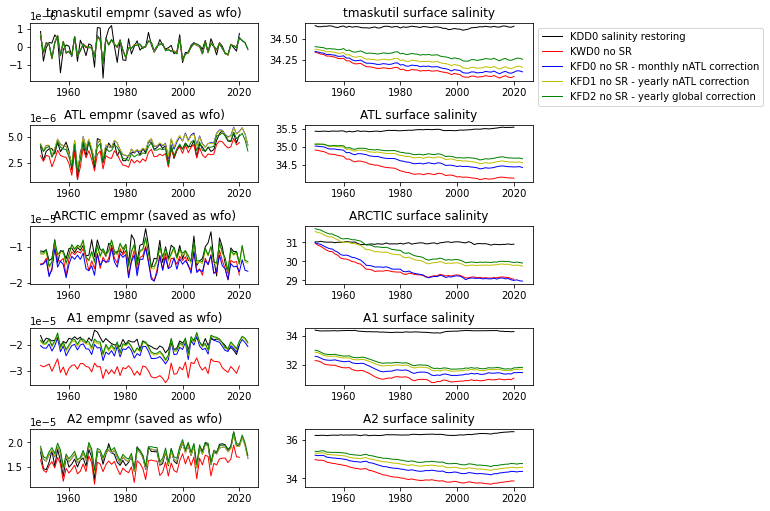

In [44]:
#KDD0 / KDB0 or KW of the same

colors_dict = {
    'KDD0': 'k', 
    'KWD0': 'r', 
    'KFD0': 'b',
    'KFD1': 'y',
    'KFD2': 'g',
}

lab_dic = {
    'KDD0': 'salinity restoring', 
    'KWD0': 'no SR', 
    'KFD0': 'no SR - monthly nATL correction',
    'KFD1': 'no SR - yearly nATL correction',
    'KFD2': 'no SR - yearly global correction',
}


mods = ['KDD0','KWD0','KFD0','KFD1', 'KFD2']#'R4D1',

fact = 0.9
fig, axs = plt.subplots(5,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

regs = ['tmaskutil','ATL','ARCTIC','A1','A2']

ind = 0

    
for treg in regs:
    for mod in mods:

        tvar = 'wfo'
        w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
        tmask['test'] = tmask['csize']*tmask[treg]
        w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
        tval = w.indexes['time_counter'].to_datetimeindex()
        w['time_counter'] = tval
        w1 = w.groupby('time_counter.year').mean()
        axs[ind*2].plot(w1.year, w1, 
                 color = colors_dict[mod], lw = 1, label = f'{mod} {lab_dic[mod]}')
        
        tvar = 'sos'
        w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
        tmask['test'] = tmask['csize']*tmask[treg]
        w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
        tval = w.indexes['time_counter'].to_datetimeindex()
        w['time_counter'] = tval
        w1 = w.groupby('time_counter.year').mean()
        axs[ind*2+1].plot(w1.year, w1, 
                 color = colors_dict[mod], lw = 1, label = f'{mod} {lab_dic[mod]}')
        
        axs[ind*2+0].set_title(f'{treg} empmr (saved as wfo)')
        axs[ind*2+1].set_title(f'{treg} surface salinity')
    ind= ind+1
    
axs[1].legend(bbox_to_anchor = [1,1])

plt.tight_layout()

## amoc

In [41]:
def make_yearlist_AMOC(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

mods = ['KDD0','KWD0','KFD0','KFD1', 'KFD2']

KFD0_moc = make_yearlist_AMOC(1920, 2023, 'TOM12_TJ_KFD0')
KFD0_mocdat = xr.open_mfdataset(KFD0_moc)
KFD0_max_amoc = get_max_amoc(KFD0_mocdat)
nicetime  = KFD0_mocdat.indexes['time_counter'].to_datetimeindex()
data_vars = {'amoc':(['time_counter'], KFD0_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
KFD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

KFD1_moc = make_yearlist_AMOC(1920, 2023, 'TOM12_TJ_KFD1')
KFD1_mocdat = xr.open_mfdataset(KFD1_moc)
KFD1_max_amoc = get_max_amoc(KFD1_mocdat)
nicetime  = KFD1_mocdat.indexes['time_counter'].to_datetimeindex()
data_vars = {'amoc':(['time_counter'], KFD1_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
KFD1_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

KFD2_moc = make_yearlist_AMOC(1920, 2023, 'TOM12_TJ_KFD2')
KFD2_mocdat = xr.open_mfdataset(KFD2_moc)
KFD2_max_amoc = get_max_amoc(KFD2_mocdat)
nicetime  = KFD2_mocdat.indexes['time_counter'].to_datetimeindex()
data_vars = {'amoc':(['time_counter'], KFD2_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
KFD2_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

KDD0_moc = make_yearlist_AMOC(1920, 2023, 'TOM12_TJ_KDD0')
KDD0_mocdat = xr.open_mfdataset(KDD0_moc)
KDD0_max_amoc = get_max_amoc(KDD0_mocdat)
nicetime  = KDD0_mocdat.indexes['time_counter'].to_datetimeindex()
data_vars = {'amoc':(['time_counter'], KDD0_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
KDD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

KWD0_moc = make_yearlist_AMOC(1920, 2023, 'TOM12_TJ_KWD0')
KWD0_mocdat = xr.open_mfdataset(KWD0_moc)
KWD0_max_amoc = get_max_amoc(KWD0_mocdat)
nicetime  = KWD0_mocdat.indexes['time_counter'].to_datetimeindex()
data_vars = {'amoc':(['time_counter'], KWD0_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
KWD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)

In [42]:
KDD0yr = KDD0_max_amoc.groupby('time_counter.year').mean()
KWD0yr = KWD0_max_amoc.groupby('time_counter.year').mean()
KFD0yr = KFD0_max_amoc.groupby('time_counter.year').mean()
KFD1yr = KFD1_max_amoc.groupby('time_counter.year').mean()
KFD2yr = KFD2_max_amoc.groupby('time_counter.year').mean()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


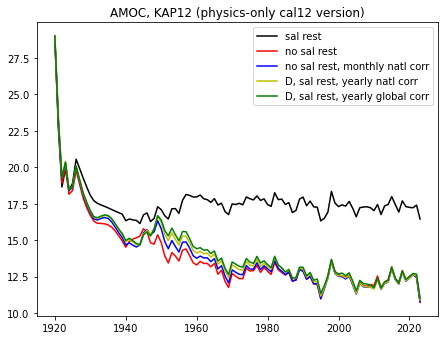

In [43]:
fact = 0.9
fig, axs = plt.subplots(1,1, figsize=(8*fact, 6*fact), facecolor='w', edgecolor='k')


axs.set_title('AMOC, KAP12 (physics-only cal12 version)')
axs.legend()

axs.plot(KDD0yr.year, KDD0yr.amoc, label = 'sal rest', color = colors_dict['KDD0'])
axs.plot(KWD0yr.year, KWD0yr.amoc, label = 'no sal rest', color = colors_dict['KWD0'])
axs.plot(KFD0yr.year, KFD0yr.amoc, label = 'no sal rest, monthly natl corr', color = colors_dict['KFD0'])
axs.plot(KFD1yr.year, KFD1yr.amoc, label = 'D, sal rest, yearly natl corr', color = colors_dict['KFD1'])
axs.plot(KFD2yr.year, KFD2yr.amoc, label = 'D, sal rest, yearly global corr', color = colors_dict['KFD2'])


axs.legend(loc = 'best')

## salinity maps

KWD0
KFD0
KFD1
KFD2


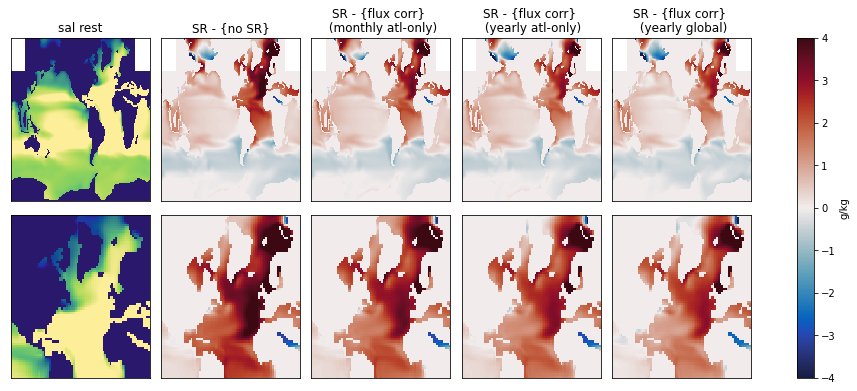

In [84]:
mods = ['KDD0','KWD0','KFD0','KFD1', 'KFD2']

tvark = 'sos'
mod = 'KDD0'
w = xr.open_dataset(f'./data/{mod}_{tvark}.nc')


fact = 1.1
fig, axs = plt.subplots(2,5, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


tvar = w.sos[360:840,:,:].mean(dim = 'time_counter')

axs[0].pcolormesh(tvar, cmap = cm.haline, vmin = 30, vmax = 35)
axs[0+5].pcolormesh(tvar, cmap = cm.haline, vmin = 30, vmax = 35)
axs[0+5].set_xlim([80,160]); axs[0+5].set_ylim([75,149]); 

for i in range(1,5):
    print(mods[i])
    w = xr.open_dataset(f'./data/{mods[i]}_{tvark}.nc')
    tvar2 = w.sos[360:840,:,:].mean(dim = 'time_counter')
    im = axs[i].pcolormesh(tvar-tvar2, cmap = cm.balance, vmin = -4, vmax = 4)
    axs[i+5].pcolormesh(tvar-tvar2, cmap = cm.balance, vmin = -4, vmax = 4)
    axs[i+5].set_xlim([80,160]); axs[i+5].set_ylim([75,149]); 
    
for i in range(0,10):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
tits = ['sal rest', 'SR - {no SR}', 'SR - {flux corr} \n (monthly atl-only)',\
        'SR - {flux corr} \n (yearly atl-only)', 'SR - {flux corr} \n (yearly global)']
for i in range (0,5):
    axs[i].set_title(tits[i])
    
plt.tight_layout()
cbar = fig.colorbar(im, ax=axs, orientation='vertical')
cbar.set_label("g/kg")